참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 13.8 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=ce23487b36e3ed4629a0868bacc2e904880862355ea3c79ba01796f6570b0290
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1381k  100 1381k    0     0   761k      0  0:00:01  0:00:01 --:--:-- 6792k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [8]:
train_data['label'].value_counts()

,count
label,
1,80003
0,79923


### 데이터 정제 및 전처리

In [9]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-9-b3393058b13d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)
<ipython-input-9-b3393058b13d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

### 토큰화

In [11]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/nlp/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs) #형태소분리
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list]) #불용어제거

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [12]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [13]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [14]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') # Out-Of-Vocabulary OOV로 대체
tokenizer.fit_on_texts(X_train) # vocab 생성
X_train = tokenizer.texts_to_sequences(X_train) # 정수 시퀀스 변환
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [15]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


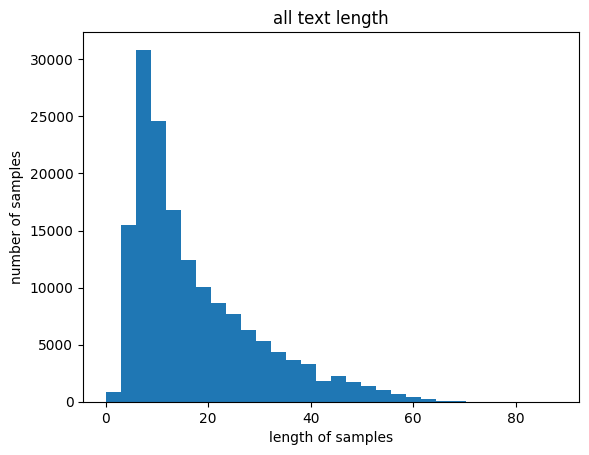

In [16]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [18]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 퀴즈

문제: 패딩을 하는 이유는 무엇일까요? (어떤 경우에 사용하는지 생각해보세요)

답변: 입력 시퀀스의 길이를 일정하게 맞춰주기 위해서. 동일한 길이의 경우 샘플을 하나의 배치로 묶어 병렬적으로 계산 가능.

In [19]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [20]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [21]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [23]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [26]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss() # 출력 dim 4 => 다중 분류 문제

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [28]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train() #학습모드

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #기울기초기화

        logits = model(text).to(device) #예측값계산



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels) #crossentropy 손실 계산

        loss.backward() #역전파

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step() #가중치업데이트

        iter += 1

        if iter % 500 == 0: #성능평가
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.21874728798866272. Accuracy: 86.59146881103516
Iteration: 1000. Loss: 0.23256604373455048. Accuracy: 88.18718719482422
Iteration: 1500. Loss: 0.17195852100849152. Accuracy: 89.11760711669922
Iteration: 2000. Loss: 0.4264098107814789. Accuracy: 88.61737823486328
Iteration: 2500. Loss: 0.29998478293418884. Accuracy: 88.20719146728516
Iteration: 3000. Loss: 0.3427650034427643. Accuracy: 88.36726379394531
Iteration: 3500. Loss: 0.30400970578193665. Accuracy: 88.56985473632812
Iteration: 4000. Loss: 0.4264912009239197. Accuracy: 87.41934204101562
Iteration: 4500. Loss: 0.2888481616973877. Accuracy: 88.07213592529297
Iteration: 5000. Loss: 0.37889930605888367. Accuracy: 88.10714721679688
Iteration: 5500. Loss: 0.3239135444164276. Accuracy: 88.62488555908203
Iteration: 6000. Loss: 0.4403533339500427. Accuracy: 85.23585510253906
Iteration: 6500. Loss: 0.3087581396102905. Accuracy: 86.68400573730469
Iteration: 7000. Loss: 0.32524940371513367. Accuracy: 87.7820053100586
I

### 모델학습 (LSTM, Long short term memory)

In [29]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim # 은닉층 크기
        self.layer_dim = layer_dim # lstm 층 수

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # 임베딩 정의

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        ) # 입력 차원 / 은닉층 크기 / 층 수 / 드롭아웃 확률

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text) # 텍스트 임베딩

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [46]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [47]:
####### 2분 17초
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.2090488225221634. Accuracy: 90.7608413696289
Iteration: 2000. Loss: 0.30933743715286255. Accuracy: 91.58871459960938
Iteration: 3000. Loss: 0.1787714958190918. Accuracy: 91.77880096435547
Iteration: 4000. Loss: 0.24367764592170715. Accuracy: 91.88884735107422
Iteration: 5000. Loss: 0.25817355513572693. Accuracy: 91.86634063720703
Iteration: 6000. Loss: 0.10607641190290451. Accuracy: 91.7587890625
Iteration: 7000. Loss: 0.09121609479188919. Accuracy: 91.70126342773438
Iteration: 8000. Loss: 0.09227684140205383. Accuracy: 91.53369140625
Iteration: 9000. Loss: 0.05428418889641762. Accuracy: 91.55870056152344
Iteration: 10000. Loss: 0.07248412817716599. Accuracy: 91.65874481201172
Iteration: 11000. Loss: 0.051881685853004456. Accuracy: 91.26107025146484
Iteration: 12000. Loss: 0.06992312520742416. Accuracy: 91.34610748291016
Iteration: 13000. Loss: 0.06927890330553055. Accuracy: 91.07598876953125
Iteration: 14000. Loss: 0.1359064280986786. Accuracy: 91.010955810546

### 모델 학습 (Gated Recurrent Unit (GRU))

In [32]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim # 은닉층 크기
        self.layer_dim = layer_dim # GRU 층 수

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        ) # 단어 임베딩 크기 / 은닉층 크기 / 층 수 / 드롭아웃 확률

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [54]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 3
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.2, device)
model = model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

criterion = nn.CrossEntropyLoss()

In [55]:
### 2분 15초

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.47603923082351685. Accuracy: 88.85498809814453
Iteration: 2000. Loss: 0.23455868661403656. Accuracy: 90.3681640625
Iteration: 3000. Loss: 0.30450019240379333. Accuracy: 91.13851165771484
Iteration: 4000. Loss: 0.20496653020381927. Accuracy: 91.0684814453125
Iteration: 5000. Loss: 0.19456592202186584. Accuracy: 91.6912612915039
Iteration: 6000. Loss: 0.1917261779308319. Accuracy: 91.76129150390625
Iteration: 7000. Loss: 0.18975690007209778. Accuracy: 91.77379608154297
Iteration: 8000. Loss: 0.23718275129795074. Accuracy: 92.01890563964844
Iteration: 9000. Loss: 0.1820000559091568. Accuracy: 91.9989013671875
Iteration: 10000. Loss: 0.23971037566661835. Accuracy: 92.14396667480469
Iteration: 11000. Loss: 0.30530381202697754. Accuracy: 92.0389175415039
Iteration: 12000. Loss: 0.2847220301628113. Accuracy: 92.1614761352539
Iteration: 13000. Loss: 0.15689396858215332. Accuracy: 91.89635467529297
Iteration: 14000. Loss: 0.20783215761184692. Accuracy: 91.99139404296875

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

Vanilla RNN의 최종 성능이 88.49인 것에 비해 LSTM(90.57)과 GRU(90.01)의 전체적인 성능은 비슷하게 나타났으며 시간 차이 또한 2분 17초와 2분 15초로 거의 동일한 길이를 보였다. 이는 장기 기억에 강점을 보이는 LSTM과 GRU 모델에 비해 단순한 RNN 모델이 한계를 보인 것으로 생각된다. 이후 파라미터 조정 실험은 상대적으로 시간이 짧을 것으로 기대되는 GRU를 기준으로 행하였다.

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4 drop_out = 0.5::: 최종 90.01 ### 기존

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 2
output_dim = 4 drop_out = 0.5::: 최종 90.03 ### layer 하나 늘림

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 2
output_dim = 4 drop_out = 0.2::: 최종 90.35 ### layer 하나 늘림 / 드롭아웃 확률 낮춤

torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9) ::: 최종 91.02 ### 옵티마이저 변경 RMSprop

torch.optim.RMSprop(model.parameters(), lr=0.005, alpha=0.9) ::: 최종 90.75 ### learning rate 변경

torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9) / layer_dim=3 시도 ::: 최종 91.27 ===best!